In [ ]:
!pip install ipywidgets transformers[torch] datasets ipywidgets torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (5.1.0)/charset_normalizer (None) doesn't match a supported version!
  warnings.warn(


# Finetune BLIP1(base) - SLAKE - 100 epochs 

In [2]:
from datasets import load_dataset
dataset = load_dataset("mdwiratathya/SLAKE-vqa-english")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 4919
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1053
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1061
    })
})

Question: Which part of the body does this image belong to?
Answer: Abdomen


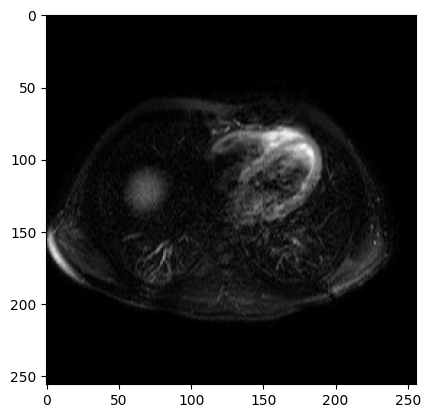

In [4]:
sample = dataset['train'][1]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [5]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

In [7]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

In [8]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [9]:
train_data = dataset['train']
val_data = dataset['test']

train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=val_data,
                     segment='test',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

In [10]:
train_vqa_dataset[0]

{'input_ids': tensor([  101,  2054, 16913, 23732,  2003,  2109,  2000,  2202,  2023,  3746,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         ...,
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],

        [[-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
         [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.752

In [11]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


In [13]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering


In [14]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
model.cuda()
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [15]:
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] which part of the body does this image belong to? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] abdomen [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


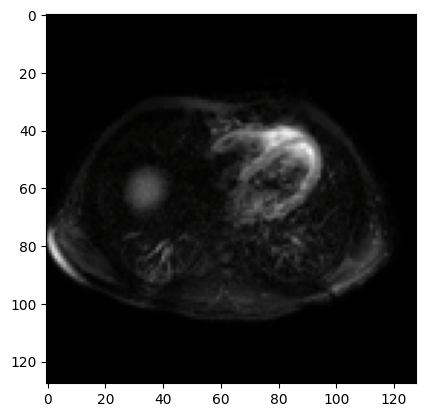

In [16]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [20]:
model.train()
for epoch in range(100):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

Epoch: 0


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.3689200012013316
Epoch: 1


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.4517434579320252
Epoch: 2


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.3708781790919602
Epoch: 3


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.4021716099232435
Epoch: 4


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.33378268731758
Epoch: 5


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.3131002432201058
Epoch: 6


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.2993834870867431
Epoch: 7


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.1824387605302036
Epoch: 8


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.161766350036487
Epoch: 9


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.1525934136006981
Epoch: 10


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.2164620435796678
Epoch: 11


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.1425982313230634
Epoch: 12


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.1052663726732135
Epoch: 13


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.1043199854902923
Epoch: 14


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.1052297879941761
Epoch: 15


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.2879576003178954
Epoch: 16


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.1915246821008623
Epoch: 17


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.108617635909468
Epoch: 18


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.0894183809868991
Epoch: 19


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.0391132112126797
Epoch: 20


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9457821757532656
Epoch: 21


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9393093187827617
Epoch: 22


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.8916810920927674
Epoch: 23


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.8991932501085103
Epoch: 24


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9754135643597692
Epoch: 25


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9245752403512597
Epoch: 26


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.8925643189577386
Epoch: 27


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9705380096565932
Epoch: 28


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.0110112967668101
Epoch: 29


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9477214638609439
Epoch: 30


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.0006349009927362
Epoch: 31


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9254644794855267
Epoch: 32


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.7926215978804976
Epoch: 33


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.7730709897587076
Epoch: 34


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.7330115808872506
Epoch: 35


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.7450278775068
Epoch: 36


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.703209430561401


In [21]:
# Assuming 'model' is your fine-tuned model and 'processor' is your tokenizer/processor
save_directory = "D:/MedVQA/blip1(base)-slake-adamW-100epochs"

# Save the fine-tuned model and processor locally
model.save_pretrained(save_directory)
#text_processor.save_pretrained(save_directory)
#image_processor.save_pretrained(save_directory)
processor.save_pretrained(save_directory)
print(f"Fine-tuned model and processor saved to {save_directory}")

Fine-tuned model and processor saved to D:/MedVQA/blip1(base)-slake-adamW-100epochs


In [22]:
model.eval()

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [23]:
def evaluate_model(model, dataloader, processor, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Convert input_ids to tensor
            input_ids = torch.tensor(batch['input_ids']).to(device)
            
            # Generate predictions
            predictions = model.generate(
                pixel_values=batch['pixel_values'],
                input_ids=input_ids,  # Pass input_ids as tensor
                attention_mask=batch['attention_mask'],
                max_length=32
            )
            
            # Decode predictions and labels
            decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
            decoded_labels = processor.batch_decode(batch['labels'], skip_special_tokens=True)
            
            # Calculate accuracy
            for pred, label in zip(decoded_preds, decoded_labels):
                if pred.strip().lower() == label.strip().lower():
                    total_correct += 1
                total_samples += 1
    
    avg_val_loss = total_loss / len(dataloader)
    val_accuracy = total_correct / total_samples
    return avg_val_loss, val_accuracy

# Evaluate the model
val_loss, val_accuracy = evaluate_model(model, val_dataloader, processor, device)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

  0%|          | 0/17 [00:00<?, ?it/s]

C:\Users\LABICA\AppData\Local\Temp\ipykernel_37344\2816787981.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch['input_ids']).to(device)


Validation Loss: 0.04562828076236388
Validation Accuracy: 0.6757775683317625


In [ ]:
# add batch dimension + move to GPU|
for x in range(400):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    print("###################################################################")